# The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates

Examining Explained Returns of securities around FOMC meetings

Whitepaper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4764451)

All returns and returns-statistics were calculated via basis points and not returns

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FOMCDrift\root\src")

from FOMCDataPreprocess import FOMCPreprocess
from EventDrivenSignalGenerator import EventDrivenSignalGenerator

## Data Prep

In [3]:
def get_tsy() -> pd.DataFrame: 
    
    df_tsy = (EventDrivenSignalGenerator().get_tsy_futures().rename(
        columns = {"security": "variable"}).
        assign(variable = lambda x: x.variable.str.split(" ").str[0]))
    
    return df_tsy

def get_tsy_window(df_tsy: pd.DataFrame, before: int = -6, after: int = 1) -> pd.DataFrame:
    
    df_out = (EventDrivenSignalGenerator().get_ordered_window(
        df     = df_tsy,
        before = before,
        after  = after).
        merge(right = FOMCPreprocess().prep_nlp(), how = "inner", on = ["date"]))
    
    return df_out

df_tsy    = get_tsy()
df_window = get_tsy_window(df_tsy)

## Returns Playback

In this case there are 2 sentiment drivers that are not useful. Although they're results should be disregarded the computational cost is so minimal its worth including. Those two sentiment drivers are <br>
1. Bloomberg Economics Decomposition of US Exchange Rate - Risk Sentiment News
2. Bloomberg Economics Decomposition of US S&P 500 - Risk Sentiment News

Although the second could be used later when the cross-asset model which is useful. First start with comparing z-scores of the event. The paper uses a method of medians which will be used later

In [4]:
def nlp_conditioned_zscore(df_window: pd.DataFrame, window: int = -4) -> pd.DataFrame:  
    
    df_prep = (df_window.query(
        "day == @window")
        [["event", "security", "z_score"]].
        drop_duplicates().
        rename(columns = {"z_score": "condition"}).
        merge(right = df_window, how = "inner", on = ["event", "security"])
        [["security", "condition", "variable", "PX_bps", "plot_name", "day"]].
        assign(condition = lambda x: np.where(x.condition > 0, "Positive Z-Score", "Negative Z-Score")).
        groupby(["security", "condition", "variable", "plot_name", "day"]).
        agg("mean").
        reset_index())
    
    return df_prep

df_zscore = nlp_conditioned_zscore(df_window)

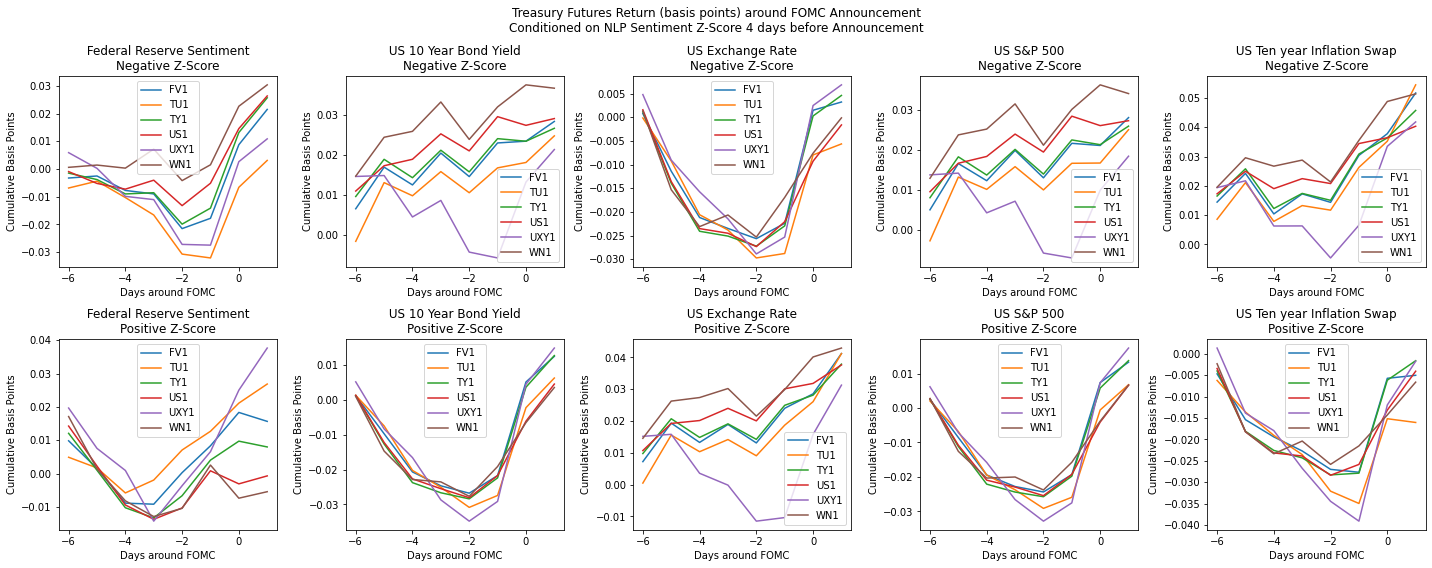

In [5]:
def plot_event_zscore_rtn_playback(df_zscore: pd.DataFrame) -> pd.DataFrame: 
    
    df_plot = (df_zscore.assign(
        group_var = lambda x: x.plot_name.str.replace("\n", "") + "\n" + x.condition).
        sort_values(["condition", "plot_name"]))

    group_vars = df_plot.group_var.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 5, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_plot.query(
            "group_var == @group_var")
            [["day", "variable", "PX_bps"]].
            rename(columns = {"variable": ""}).
            pivot(index = "day", columns = "", values = "PX_bps").
            cumsum().
            plot(
                title  = group_var,
                ax     = ax,
                ylabel = "Cumulative Basis Points",
                xlabel = "Days around FOMC"))

    fig.suptitle("Treasury Futures Return (basis points) around FOMC Announcement\nConditioned on NLP Sentiment Z-Score 4 days before Announcement")
    plt.tight_layout()
    
plot_event_zscore_rtn_playback(df_zscore)

In this case let's create a naive strategy that trades treasury futures conditioned on the z-score. <br>
While this is a bit of an overstretch we'll use the z-score sign as a method for whether or not trading. These are the conditions to meet <br>
1. Federal Reserve Sentiment Positive Z-Score
2. US 10Y bond Yield Positive Z-Score
3. US Exchange Rate Negative Z-Score
4. S&P 500 Positive Z-Score
5. US Ten Year Inflation Swap Positive Z-Score

There is an economic interpretation to this choice, all are positive z-scores, with the one exception of US exchange rate being a negative z-score. 

In [6]:
def get_zscore_backtest(df_window: pd.DataFrame, window: int = -4, start: int = -3, end: int = -1) -> pd.DataFrame: 

    df_match = (df_window[
        ["security"]].
        drop_duplicates().
        assign(match_condition = lambda x: np.where(x.security == "APUSXRGF", -1, 1)))

    df_out = (df_window.query(
        "day == @window")
        [["event", "security", "z_score"]].
        drop_duplicates().
        rename(columns = {"z_score": "condition"}).
        merge(right = df_window, how = "inner", on = ["event", "security"]).
        drop(columns = [
            "roll_mean", "roll_std", "z_score", "lag_zscore", "PX_LAST", "PX_diff", 
            "PX_pct", "Description"]).
        assign(condition_sign = lambda x: np.sign(x.condition)).
        merge(right = df_match, how = "inner", on = ["security"]).
        query("condition_sign == match_condition").
        query("@start <= day <= @end"))
    
    return df_out

df_zscore_backtest = get_zscore_backtest(df_window)

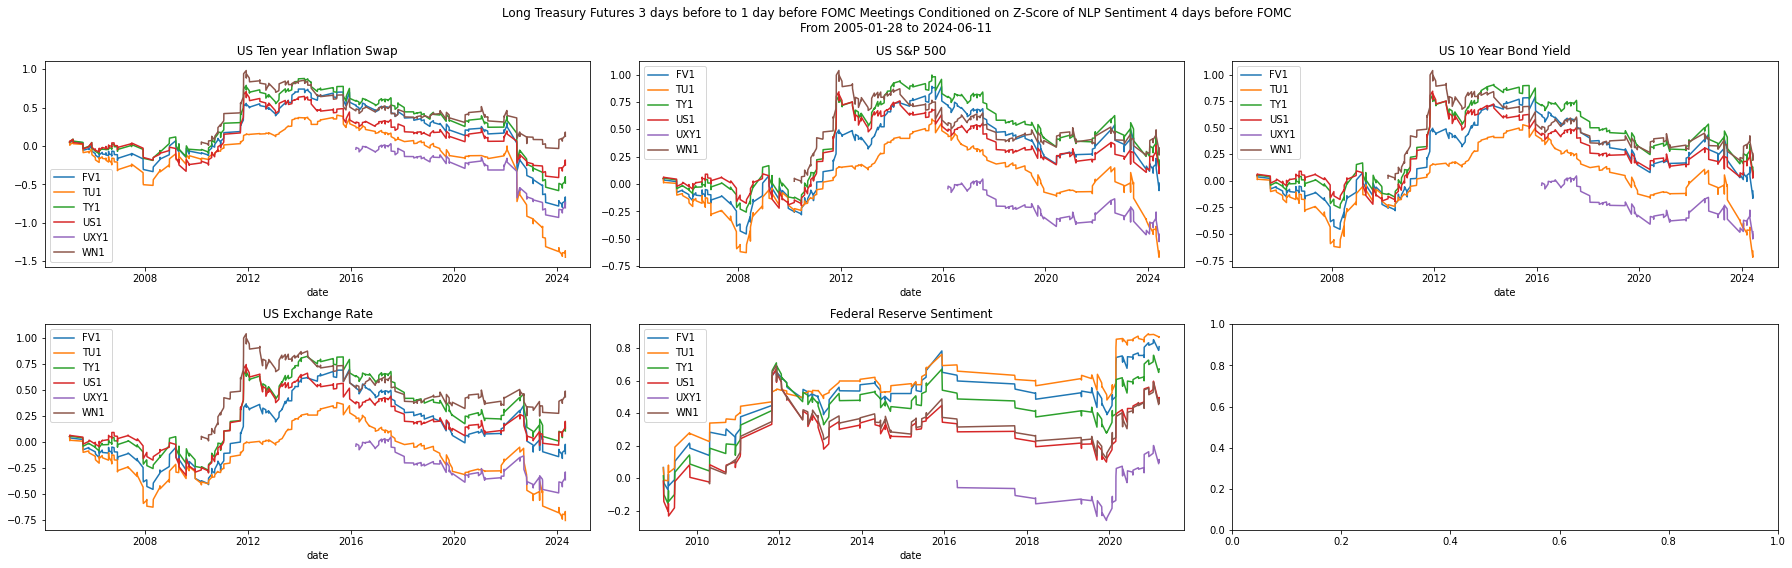

In [7]:
def plot_zscore_backtest(df_zscore_backtest: pd.DataFrame) -> plt.Figure: 
    
    group_vars = df_zscore_backtest.plot_name.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = int(len(group_vars) * 0.75), nrows = len(group_vars) // 2, figsize = (25,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_zscore_backtest.query(
            "plot_name == @group_var")
            [["date", "variable", "PX_bps"]].
            rename(columns = {"variable": ""}).
            pivot(index = "date", columns = "", values = "PX_bps").
            cumsum().
            plot(
                ax    = ax,
                title = group_var.replace("\n", "")))

    fig.suptitle("Long Treasury Futures 3 days before to 1 day before FOMC Meetings Conditioned on Z-Score of NLP Sentiment 4 days before FOMC\nFrom {} to {}".format(
        df_zscore_backtest.date.min(),
        df_zscore_backtest.date.max()))

    plt.tight_layout()
    
plot_zscore_backtest(df_zscore_backtest)

In this case most of the performance is sub-par the strategies don't consistently make money, have consistent negative returns before giving positive returns and then give back most of their returns toward the end.

In [8]:
def get_zscore_sharpe(df_zscore_backtest: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_zscore_backtest[
        ["plot_name", "variable", "PX_bps"]].
        groupby(["plot_name", "variable"]).
        agg(["mean", "std"])
        ["PX_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(8)).
        reset_index())
    
    return df_sharpe

df_zscore_sharpe = get_zscore_sharpe(df_zscore_backtest)

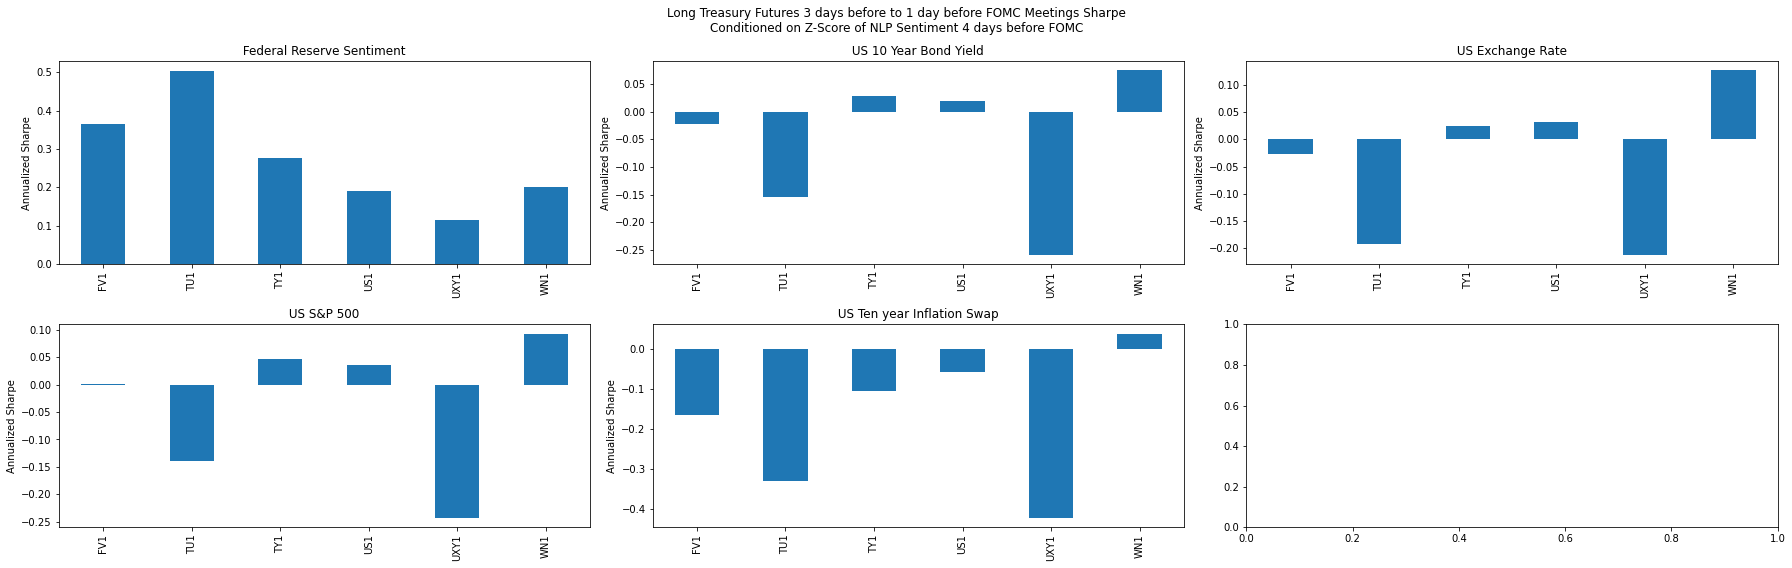

In [9]:
def plot_zscore_sharpe(df_zscore_sharpe: pd.DataFrame) -> plt.Figure: 
    
    group_vars = df_zscore_sharpe.plot_name.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = int(len(group_vars) * 0.75), nrows = len(group_vars) // 2, figsize = (25,8))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_zscore_sharpe.query(
            "plot_name == @group_var").
            set_index("variable")
            [["sharpe"]].
            plot(
                ax     = ax,
                kind   = "bar",
                legend = False,
                ylabel = "Annualized Sharpe",
                xlabel = "",
                title  = group_var.replace("\n", "")))

    fig.suptitle("Long Treasury Futures 3 days before to 1 day before FOMC Meetings Sharpe\nConditioned on Z-Score of NLP Sentiment 4 days before FOMC")
    plt.tight_layout()
    
plot_zscore_sharpe(df_zscore_sharpe)

The results are quite bad, there are a couple of noticable things to point out. 
1. Federal Reserve sharpes are good but they occur at a lower frequency (which will be examined before)
2. The sharpes have low absolute values and aren't consistent across strategies
3. Sharpes for UXY look consistently negative which would imply that going short for UXY is profitable. This is likely not true since the returns of UXY are consistent with the other futures, it occurs because UXY was created in 2016 and the return stream for UXY during the *give-back* phase of backtest. 
4. TU could possible be flipped to short although the sharpes would be around ~0.3 which is still subpar for Treasury futures trading strateiges. Adding in an extra parameter for positioning per contract could lead to overfitting. The model has already look-ahead snooped when creating the "returns-around-FOMC" plots

Let's examine how "tradable" the Federal Reserve Sentiment Score is

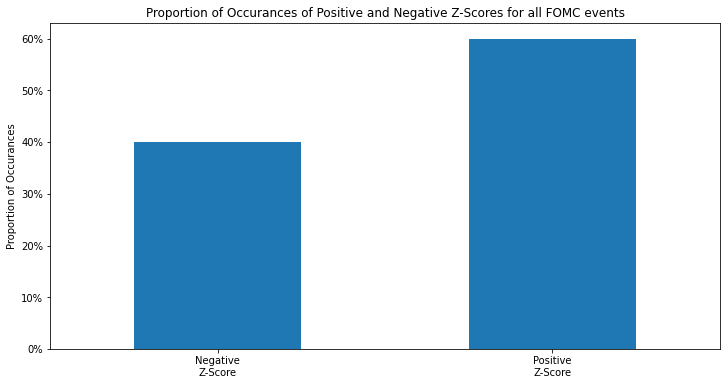

In [10]:
def plot_benlpfed_proportion(df_window: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_window.query(
        "security == 'BENLPFED'").
        query("day == -4")
        [["event", "value"]].
        drop_duplicates().
        assign(
            value     = lambda x: np.sign(x.value),
            condition = lambda x: np.where(x.value == 1, "Positive\nZ-Score", "Negative\nZ-Score")).
        drop(columns = ["value"]).
        groupby("condition").
        agg("count").
        assign(proportion = lambda x: x.event / x.event.sum())
        [["proportion"]].
        plot(
            ax     = axes,
            kind   = "bar",
            legend = False,
            xlabel = "",
            ylabel = "Proportion of Occurances",
            title  = "Proportion of Occurances of Positive and Negative Z-Scores for all FOMC events"))

    axes.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    axes.tick_params(axis='x', labelrotation=0)
    
plot_benlpfed_proportion(df_window)